Experiment A: Clustering in the location + ratio space

In [60]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import SpectralClustering
import warnings
warnings.filterwarnings("ignore")

In [61]:
def identify_spec(label):
    q_index = label.find('Q')
    if q_index == -1 or q_index == len(label) - 1:
        return '/'
    return label[q_index: q_index + 2]

In [62]:
# Morphological traits 1 ~ 16
df = pd.read_csv('data/ancestry.csv')

df["spec"] = df["morphological_tree_number"].apply(identify_spec)
df = df.drop(columns=["morphological_tree_number", "idx", "SNMF_genetic_label"])

df.head()


,V1,V2,V3,V4,spec
0,0.095385,0.000100,0.885196,0.019319,QR
1,0.807307,0.052619,0.113629,0.026444,QA
2,0.365497,0.464203,0.139003,0.031296,QS
3,0.119371,0.199143,0.643418,0.038068,QR
4,0.933324,0.037291,0.012195,0.017190,QA


In [63]:
data = df.drop(columns=["spec"])

In [64]:
# Perform spectral clustering
spectral = SpectralClustering(n_clusters=4, random_state=0)
cluster_labels = spectral.fit_predict(data)

# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)



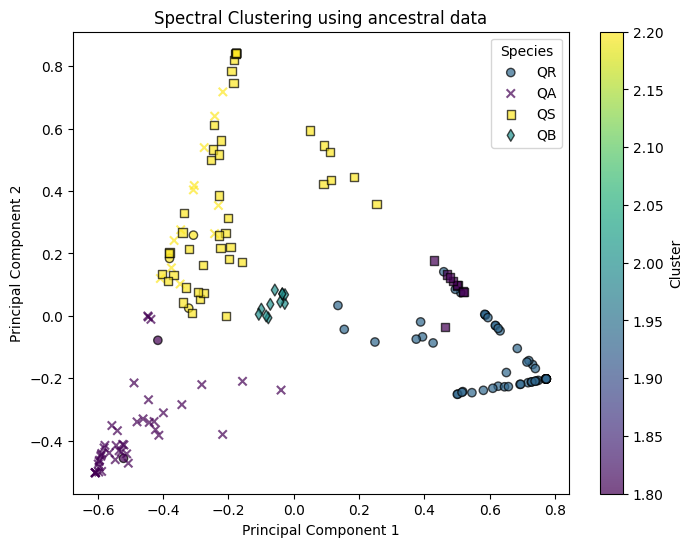

In [65]:
# Create a DataFrame for plotting
species_labels = df['spec']  # Ensure df['spp'] exists and contains species information

# Map species to markers
unique_species = species_labels.unique()
markers = ['o', 'x', 's', 'd', '*', 'p', '^', '<', '>']
species_to_marker = {species: markers[i % len(markers)] for i, species in enumerate(unique_species)}

# Plot the PCA-transformed data with species-specific markers and GMM cluster colors
plt.figure(figsize=(8, 6))
for species, marker in species_to_marker.items():
    species_data = data_pca[species_labels == species]
    species_cluster_labels = cluster_labels[species_labels == species]
    plt.scatter(species_data[:, 0], species_data[:, 1], c=species_cluster_labels, marker=marker, label=species, edgecolor='k', alpha=0.7, cmap='viridis')

plt.title('Spectral Clustering using ancestral data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Species')
plt.colorbar(label='Cluster')
plt.show()


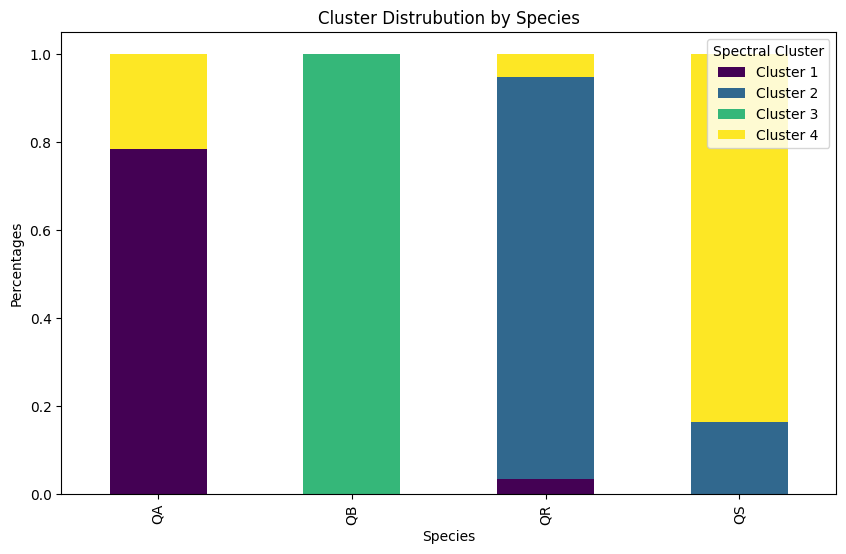

In [70]:
# Create a DataFrame for plotting
species_labels = df['spec']
plot_data = pd.DataFrame({'species': species_labels, 'cluster': cluster_labels})
cluster_counts = plot_data.groupby(['species', 'cluster']).size().unstack(fill_value=0)

# Normalize the counts to get proportions
cluster_proportions = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

# Plotting
cluster_proportions.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Cluster Distrubution by Species')
plt.xlabel('Species')
plt.ylabel('Percentages')
plt.legend(title='Spectral Cluster', labels=[f'Cluster {x}' for x in range(1, 5)])
plt.show()

In [67]:
species_labels = species_labels.to_numpy()
print("Adjusted Rand Index:", adjusted_rand_score(species_labels, cluster_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(species_labels, cluster_labels))

Adjusted Rand Index: 0.6272215717247943
Normalized Mutual Information: 0.6698212378219845


In [68]:
def make_binary(row):
    rowlist = np.array([row['V1'], row['V2'], row['V3'], row['V4']])
    ref = np.array([1,0.2,0.1,0])
    #ref = np.array([1,0,0,0])
    result = np.zeros_like(rowlist)

    sorted_indices = np.argsort(-rowlist)
    for i, idx in enumerate(sorted_indices):
        result[idx] = ref[i]
    
    return pd.Series(result)

df = pd.read_csv('data/ancestry.csv')

df[['V1','V2','V3','V4']]  = df.apply(make_binary,axis=1)
df["spec"] = df["morphological_tree_number"].apply(identify_spec)
df = df.drop(columns=["morphological_tree_number", "idx", "SNMF_genetic_label"])

df.head()


,V1,V2,V3,V4,spec
0,0.2,0.0,1.0,0.1,QR
1,1.0,0.1,0.2,0.0,QA
2,0.2,1.0,0.1,0.0,QS
3,0.1,0.2,1.0,0.0,QR
4,1.0,0.2,0.0,0.1,QA
